In [2]:
import pandas as pd
import numpy as np
# from scipy.stats import pearsonr, median_abs_deviation
# from sklearn import metrics
import sys
import os
from statsmodels.stats.multitest import multipletests
from scipy.stats import combine_pvalues, norm, mannwhitneyu, spearmanr, pearsonr
from read_clustering.variant_call import VariantCalls
import matplotlib.pyplot as plt
from scipy.stats import shapiro, combine_pvalues
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy.stats import combine_pvalues, norm, mannwhitneyu
from scipy.stats import chi2_contingency

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# final ivt vs native
CBF5GAL = "modification_calls/20190610_R941_CBF5GAL.csv"
CBF5GLU = "modification_calls/20190611_R941_CBF5GLU.csv"
NOP58GAL = "modification_calls/20190617_R941_NOP58GAL.csv"
NOP58GLU = "modification_calls/20190619_R941_NOP58GLU.csv"
IVT = "modification_calls/20191014_R941_IVT.csv"
mutant448 = "modification_calls/20210405_R941_mutant448.csv"
WT_YPD = "modification_calls/20210410_R941_WT_YPD.csv"
WT_KOAC = "modification_calls/20210412_R941_WT_KOAC.csv"
mutant452 = "modification_calls/20210413_R941_mutant452.csv"
WT_CY = "modification_calls/20210414_R941_WT_CY.csv"
mutant451 = "modification_calls/20210415_R941_mutant451.csv"
WT_PB = "modification_calls/20210520_R941_WT_PB.csv"
WT_stationary = "modification_calls/20210521_R941_WT_stationary.csv"
Dbp3d_YPD = "modification_calls/20210527_R941_Dbp3d_YPD.csv"
trl1d_YPD = "modification_calls/20210528_R941_trl1d_YPD.csv"
WT_rapa5 = "modification_calls/20210531_R941_WT_rapa5.csv"
Mix = "modification_calls/20210618_R941_Mix.csv"
prp43 = "modification_calls/20210619_R941_prp43.csv"
MIX_2 = "modification_calls/20210716_R941_MIX.csv"
YS602_18_YPD = "modification_calls/20210717_R941_YS602_18_YPD.csv"
prp16_18deg_YPD = "modification_calls/20210719_R941_prp16_18deg_YPD.csv"
spp382_YPD = "modification_calls/20210720_R941_spp382_YPD.csv"
YS602_18_YPD2 = "modification_calls/20210722_R941_YS602_18_YPD2.csv"
dbr1d_YPD = "modification_calls/20210729_R941_dbr1d_YPD.csv"
sqs1d_YPD = "modification_calls/20210730_R941_sqs1d_YPD.csv"
snR4d_YPD = "modification_calls/20210823_R941_snR4d_YPD.csv"
snR45d_YPD = "modification_calls/20210824_R941_snR45d_YPD.csv"
mutant448_2 = "modification_calls/20210825_R941_mutant448.csv"
snR4d_alpha_YPD = "modification_calls/20210902_R941_snR4d_alpha_YPD.csv"
WT_YPD2 = "modification_calls/20210930_R941_YS602_WT_repeat2.csv"
WT_YPD3 = "modification_calls/20211001_R941_YS602_WT_repeat3.csv"
prx1 = "modification_calls/20211006_R941_pxr1d_YPD.csv"
YS602_18_YPD3 = "modification_calls/20211007_R941_YS602_18_YPD3.csv"



In [4]:
corrected_pvalues_df = pd.read_csv("figures/summary_data/all_experiment_percent_modification_corrected_pvalues_chi2.csv", 
                                   index_col=0)


NameError: name 'contig' is not defined

In [12]:
wt_labels = ["WT_YPD", "WT_YPD2", "WT_YPD3"]  
all_diffs = []
for i, wt_l in enumerate(wt_labels):
    for wt_2 in wt_labels[i+1:]:
        diff = corrected_pvalues_df[wt_l+"_mean"] - corrected_pvalues_df[wt_2+"_mean"]
        all_diffs.append(diff)
all_df = pd.DataFrame(all_diffs)
per_position_max_diff = np.abs(all_df).max()
max_diff = per_position_max_diff.max() + 0.01
title = contig
pvalue_cutoff = 0.05
width = 0.8 / 2


In [20]:
def get_precent_mod_group(labels, contig, corrected_pvalues_df, width, method="min"):
    options = ("min", "average")
    assert method in options, f"Method must be in {options}"
    if not isinstance(labels, list):
        labels = [labels]
    ###
    all_diffs = []
    for label in labels:
        for wt_l in wt_labels:
            diff = corrected_pvalues_df[f"{label}_mean"] - corrected_pvalues_df[wt_l+"_mean"]
            all_diffs.append(diff)
    all_diffs_df = pd.DataFrame(all_diffs)
    per_position_index = np.abs(pd.DataFrame(all_diffs)).idxmin()
    y_all = pd.Series(all_diffs_df.lookup(per_position_index.values, per_position_index.index), index=per_position_index.index)
    pvalue_mask = (corrected_pvalues_df[f"{label}_corrected_pvalue"] < pvalue_cutoff) * (np.abs(y_all) > per_position_max_diff+0.01) * (np.abs(y_all) > max_diff)    

    return y_all, pvalue_mask


In [35]:
def plot_percent_mod(all_labels, contig, corrected_pvalues_df, figure_path):
    wt_labels = ["WT_YPD", "WT_YPD2", "WT_YPD3"]  
    all_diffs = []
    for i, wt_l in enumerate(wt_labels):
        for wt_2 in wt_labels[i+1:]:
            diff = corrected_pvalues_df[wt_l+"_mean"] - corrected_pvalues_df[wt_2+"_mean"]
            all_diffs.append(diff)
    all_df = pd.DataFrame(all_diffs)
    per_position_max_diff = np.abs(all_df).max()
    max_diff = per_position_max_diff.max() + 0.01
    title = contig
    pvalue_cutoff = 0.05
    fig, axs = plt.subplots(1, figsize=(30,10))
    axs.set_title(title, fontdict={'fontsize':20})
    width = 0.8 / len(all_labels)
    tab_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    mask = (corrected_pvalues_df["contig"] == contig).values

    for i, label in enumerate(all_labels):
        y_all, pvalue_mask = get_precent_mod_group(label, contig, corrected_pvalues_df, width, method="min")
        #     pvalue_mask = (corrected_pvalues_df[f"{label}_corrected_pvalue"] < pvalue_cutoff) * (np.abs(y_all) > per_position_max_diff+0.01)   

        colors = pd.DataFrame([tab_colors[i] for x in pvalue_mask])
        x = y_all[mask].index
        y = y_all[mask]
        c = list(colors[mask][0].values)

        if i == 0:
    #         x1 = np.array(range(len(x)))+(0*width)
            x1 = np.array(range(len(x)))+(0.5*width)
        if i == 1:
            x1 = np.array(range(len(x)))-(0.5*width)
        if i == 2:
            x1 = np.array(range(len(x)))+(1.5*width)
        if i == 3:
            x1 = np.array(range(len(x)))-(1.5*width)
        if i == 4:
            x1 = np.array(range(len(x)))+(2.5*width)


        axs.bar(x1, y, width, label=label, color=tab_colors[i])
        axs.scatter(x1[pvalue_mask[mask]], y[pvalue_mask&mask] + (np.sign(y[pvalue_mask&mask]) * 0.015), marker="*", color="black", zorder=10, s=250)
        axs.set_xticks(ticks=[x for x in range(len(x))], minor=True)
        axs.set_xticks(ticks=[x-0.5 for x in range(len(x)+1)], minor=False)
        axs.set_yticks(ticks=np.linspace(-1, 1, num=21, endpoint=True))
        axs.set_xticklabels(labels=x, minor=True)
        axs.set_xticklabels(labels=["" for x in x], minor=False)

    #     axs.grid(True, which='minor', axis='x')
        axs.grid(True, which='major')

    axs.set_ylim(-1, 0.15)
    axs.axhline(y=max_diff)
    axs.axhline(y=-max_diff)
    x1 = np.array(range(len(x)))
    axs.bar(x1, per_position_max_diff[mask], 1, label="Max WT DIFF", color="black", alpha=0.35)
    axs.bar(x1, -per_position_max_diff[mask], 1, label="Max WT DIFF", color="black", alpha=0.35)
    plt.legend()

    if figure_path is not None:
        plt.savefig(figure_path)
    else:
        plt.show()

/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7/site-packages/pandas/core/computation/expressions.py:201: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/andrewbailey/anaconda3/envs/read_clustering/lib/python3.7

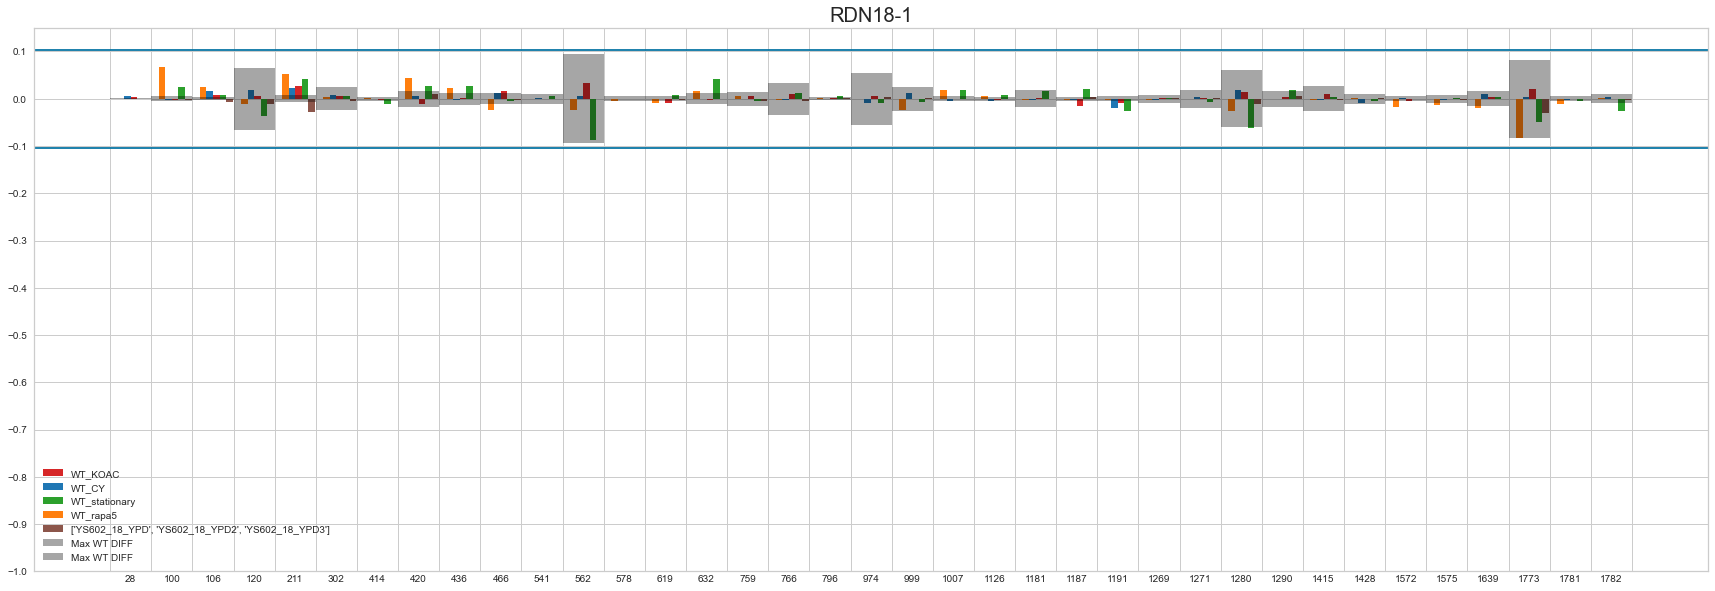

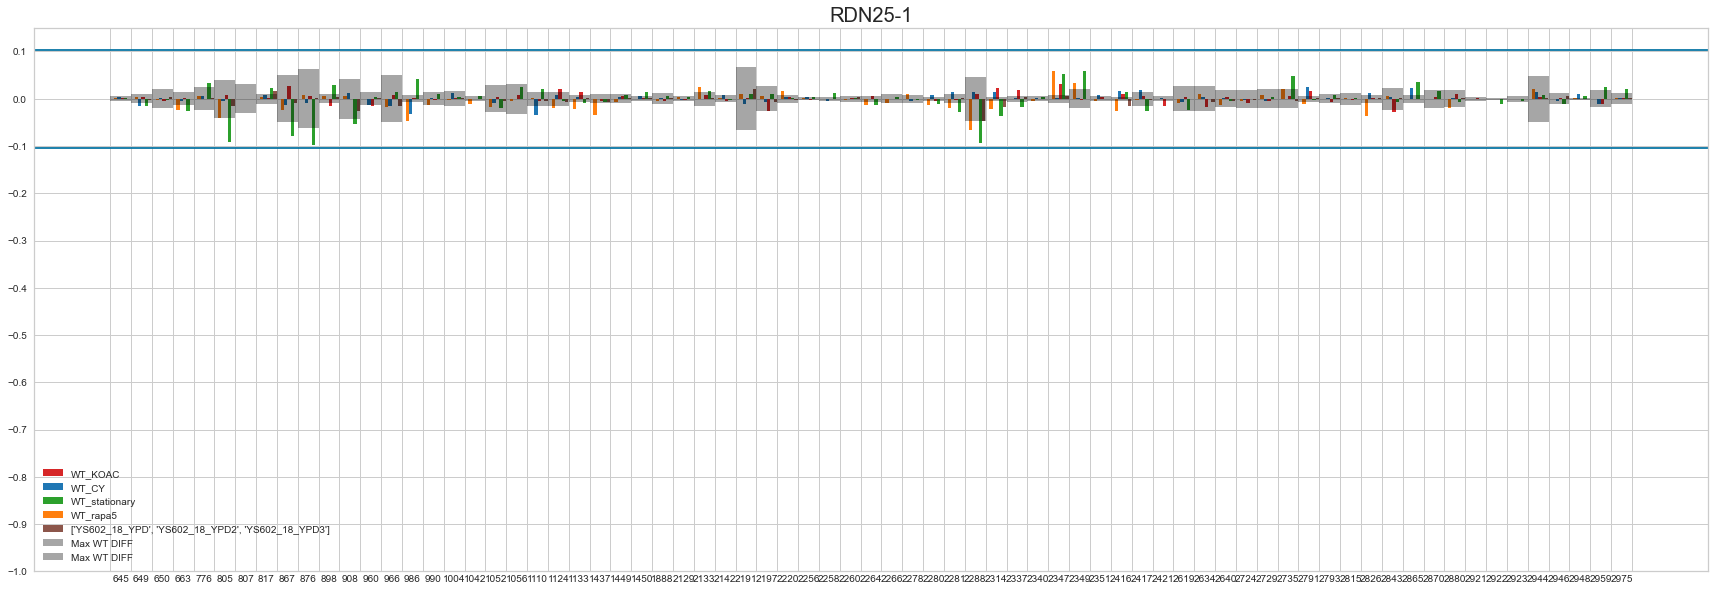

In [40]:
for contig in ["RDN18-1", "RDN25-1"]:
#     figure_path = f"figures/dbp3_prp43/{contig}_helicase_bargraph.png"
#     all_labels = ["Dbp3d_YPD", "prp43", "sqs1d_YPD", "prx1"] 
#     plot_percent_mod(all_labels, contig, corrected_pvalues_df, figure_path)

#     figure_path = f"figures/sno_rna_knockouts/{contig}_snornaKO_bargraph.png"
#     all_labels = ["snR4d_alpha_YPD", "mutant452", "mutant451", "mutant448_2", "snR45d_YPD", "MIX_2"] 
#     plot_percent_mod(all_labels, contig, corrected_pvalues_df, figure_path)

#     figure_path = f"figures/splicing_mutants/{contig}_splicing_mutations_bargraph.png"
#     all_labels = ["dbr1d_YPD", "spp382_YPD", "prp16_18deg_YPD", "WT_PB"] 
#     plot_percent_mod(all_labels, contig, corrected_pvalues_df, figure_path)

#     all_labels = ["WT_KOAC", "WT_CY", "WT_stationary", "WT_rapa5", "YS602_18_YPD", "YS602_18_YPD2", "YS602_18_YPD3"]    
#     figure_path = f"figures/wt_ivt_environment_conditions/{contig}_conditions_bargraph.png"
#     plot_percent_mod(all_labels, contig, corrected_pvalues_df, figure_path)
    all_labels = ["WT_KOAC", "WT_CY", "WT_stationary", "WT_rapa5", ["YS602_18_YPD", "YS602_18_YPD2", "YS602_18_YPD3"]]  
    figure_path = f"figures/wt_ivt_environment_conditions/{contig}_cold_conditions_bargraph.png"
    plot_percent_mod(all_labels, contig, corrected_pvalues_df, figure_path)
#              'YS602_18_YPD': {'RDN18-1': 863, 'RDN25-1': 334},
#              'YS602_18_YPD2': {'RDN18-1': 7263, 'RDN25-1': 3161},
#              'YS602_18_YPD3': {'RDN18-1': 3059, 'RDN25-1': 1225}}
